In [21]:
from commonfunctions import *
from chars_database import *
from skimage.exposure import histogram
from skimage.measure import find_contours
from skimage.filters import gaussian
import cv2 as cv
import os
from skimage import img_as_ubyte
import functools 
from func import *
import imutils
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_erosion, binary_dilation,black_tophat, binary_closing,binary_opening,skeletonize, thin,area_closing,area_opening
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)
from skimage.draw import rectangle
from skimage.filters import threshold_otsu

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def plateDetect(img):
    originalImage = np.copy(img)
    img=imutils.resize(img , width = 500)
    grayedimg=rgb2gray(img)
    img_after_orig_minus_closing=grayedimg-binary_erosion(binary_dilation(grayedimg))
    img_after_orig_minus_closing=black_tophat(grayedimg,np.ones((5,3)))
    blackhat=black_hat_cv2(grayedimg)
    blackhat=img_as_ubyte(blackhat)
    img1=binary_dilation(grayedimg,np.ones((3,3)))
    img1=binary_erosion(img1,np.ones((3,3)))
    img_thresh = img1
    img_thresh[ img1 < 50 ] = 0
    img_thresh[ img_thresh >= 50 ] = 255
    
    light_regions=find_light_regions(grayedimg)

    sobelX_cv2 = sobel_x_cv2(blackhat)
    sobelX_skimage=sobel(img_after_orig_minus_closing)

    gau_img_sk = gaussian(sobelX_skimage, sigma=0, truncate=1/5)
    gau_img_cv =gaussian_cv(sobelX_cv2)
    otsu_thresh_cv=otsu_threshold(gau_img_cv)
    thresh = threshold_otsu(gau_img_sk)
    otsu_thresh_sk = gau_img_sk > thresh

    otsu_thresh_cv=cv2.erode(otsu_thresh_cv, None, iterations = 2)
    otsu_thresh_cv = cv2.dilate(otsu_thresh_cv, None, iterations = 3)

    otsu_thresh_sk=binary_erosion(otsu_thresh_sk)
    otsu_thresh_sk=binary_erosion(otsu_thresh_sk)
    
    for i in range(0,9):    
        otsu_thresh_sk=binary_dilation(otsu_thresh_sk)
    
    for i in range(0,8):    
        otsu_thresh_sk=binary_erosion(otsu_thresh_sk)

    otsu_thresh_cv=cv2.erode(otsu_thresh_cv, None, iterations = 3)
    otsu_thresh_cv = cv2.dilate(otsu_thresh_cv, None, iterations = 6)
    otsu_thresh_cv=cv2.erode(otsu_thresh_cv, None, iterations = 8)
    otsu_thresh_cv = cv2.dilate(otsu_thresh_cv, None, iterations = 3)

    otsu_thresh_cv=cv2.erode(otsu_thresh_cv, None, iterations = 3)
    otsu_thresh_cv = cv2.dilate(otsu_thresh_cv, None, iterations = 8)
    otsu_thresh_cv=cv2.erode(otsu_thresh_cv, None, iterations = 3)

    otsu_thresh_cv=gaussian_cv(otsu_thresh_cv)
    otsu_thresh_sk=gau_img_sk = gaussian(otsu_thresh_sk, sigma=0, truncate=1/5)
    img_with_boxes= np.zeros(img.shape)
    contours = find_contours(otsu_thresh_cv, 0.8)
    bounding_boxes = []
    for contour in contours:
            box = [min(contour[:, 1]), max(contour[:, 1]), min(contour[:, 0]), max(contour[:, 0])]
            w=abs(box[0] - box[1])
            h=abs(box[2] - box[3])
            area=h*w
            ratio = w/h
            if(ratio >= 1.5 and ratio <= 3.8):   
                if(w<150 and w>50 and h<50 and h>10 and box[2]-10>0 and box[3]+10<img.shape[0]):
                     bounding_boxes.append(box)    
    cropped=img     
    plate_list=[]
    YminMapped = -1
    YmaxMapped = -1
    XminMapped = -1
    XmaxMapped = -1
    for box in bounding_boxes:
            [Xmin, Xmax, Ymin, Ymax] = box
            Xmin=int(Xmin)
            Xmax=int(Xmax)
            Ymin=int(Ymin)
            Ymax=int(Ymax)
            h=int(h)
            w=int(w)
            originalHeight = originalImage.shape[0]
            originalWidth = originalImage.shape[1]
            resizedHeight = img.shape[0]
            resizedWidth = img.shape[1]
            YminMapped = ((Ymin-15) * originalHeight) // resizedHeight
            YmaxMapped = (Ymax * originalHeight) // resizedHeight
            XminMapped = (Xmin * originalWidth) // resizedWidth
            XmaxMapped = (Xmax * originalWidth) // resizedWidth
            img_cropped=originalImage[YminMapped:YmaxMapped,XminMapped:XmaxMapped]
            [B,G,R]=[np.sum(img_cropped[:,:,0]),np.sum(img_cropped[:,:,1]),np.sum(img_cropped[:,:,2])]
            plate_list.append([img_cropped,Ymin,Ymax])
            rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
            img_with_boxes[rr.astype(int), cc.astype(int)] = 1 #set color white
            
    choosed_plate_index=-1;
    Yhigh=0
    x=0;
    if(len(plate_list)==2):
        if((plate_list[0][2]+10)>img.shape[0]):
            choosed_plate_index=1;
        elif((plate_list[1][2]+10)>img.shape[0]):
            choosed_plate_index=0;
        else:
            for z, plate_instance in enumerate(plate_list):
                if(plate_instance[1]>Yhigh):
                    Yhigh=plate_instance[1]
                    choosed_plate_index=x
                x=x+1   
    else:
         for z, plate_instance in enumerate(plate_list):
                if(plate_instance[1]>Yhigh):
                    Yhigh=plate_instance[1]
                    choosed_plate_index=x
                x=x+1 
    plate_final=[]     
    if(choosed_plate_index!=-1):
        plate_final.append(plate_list[choosed_plate_index][0])
    else:
        for plate_instance in plate_list:
            plate_final.append(plate_instance[0])
    return plate_final[0]

    

In [38]:
database_characters = []
fill_chars_database(database_characters)


In [26]:
def getError(img1, img2):
    dim = (60,60)
    img1 = cv.GaussianBlur(img1,(19,19),0)
    img2 = cv.GaussianBlur(img2,(19,19),0)
    img1 = cv.resize(img1, dim, interpolation = cv.INTER_AREA)
    img2 = cv.resize(img2, dim, interpolation = cv.INTER_AREA)
    _,img1 = cv.threshold(img1,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    _,img2 = cv.threshold(img2,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    error = img1 - img2
    error = error * error
    error = np.sum(error)
    error = np.sqrt(error)
    # sqrt(sum(square(img1 - img2)))
    return error

In [39]:
dim = (60, 60)
class characterContour:
    def __init__(self, char, template):
        self.char = char
        self.template = cv.resize(template, dim, interpolation = cv.INTER_AREA)
        self.col_sum = np.zeros(shape=(height,width))
        self.corr = 0

def detectChar(unknownChar):
    minError = 500000000000
    currError = 500000000000
    for databaseChar in database_characters:
        currError = getError(unknownChar.template,databaseChar.template)
        if currError < minError:
            unknownChar.char = databaseChar.char
            minError = currError
    return unknownChar.char

def movePointBy90(hieght, width, i, j):
    iNew = -j + width - 1
    jNew = i
    return int(iNew), int(jNew)

def rotateMatrix90(mat):
    image2 = np.zeros([mat.shape[1], mat.shape[0]])
    for i in range(mat.shape[0]-1):
        for j in range(mat.shape[1]-1):
            newPoint = movePointBy90(mat.shape[0], mat.shape[1], i, j)
            image2[newPoint[0], newPoint[1]]=mat[i,j]
    return image2
def rotateMatrixNTimes(mat, n=1):
    for i in range(0, n):
        mat = rotateMatrix90(mat)
    return mat

def checkRange(width , Xmin,Xmax):
    minWidth , maxWidth = width * 0.42 , width * 0.57
    return not( (minWidth < Xmin and Xmin < maxWidth) and (minWidth < Xmax and Xmax < maxWidth))

def checkValidContour(Xmin, Xmax, Ymin, Ymax):
    width = abs(Ymax - Ymin)
    height = abs(Xmax - Xmin)
    if(width == 0):
        width = 1
    heightOverWidth = height / width
    return (heightOverWidth >= 0.12 and heightOverWidth <= 2.9 and width > 11 and height > 3)

def detectDefect(char):
    charAvg = char.mean()
    if charAvg > 0.7:
        # many white pixels
        return True
    else:
        return False

def cropPlateFromRight(image):
    rows, cols = image.shape
    if(rows == 0):
        return image
    indexToCropFrom = -1
    for col in range(cols-1, 0, -1):
        colAvg = sum(image[:,col]) / rows
        if(colAvg > 0.7):
            indexToCropFrom = col
            break
    image = image[:,:indexToCropFrom]
    return image

def cropPlateFromLeft(image):
    rows, cols = image.shape
    if(rows == 0):
        return image
    indexToCropFrom = -1
    for col in range(0, cols):
        colAvg = sum(image[:,col]) / rows
        if(colAvg > 0.7):
            indexToCropFrom = col
            break
    image = image[:,indexToCropFrom:cols]
    return image

def cropPlateFromTop(image):
    rows, cols = image.shape
    if(cols == 0):
        return image
    indexToCropFrom = -1
    for row in range(0, rows):
        rowAvg = sum(image[row]) / cols
        if(rowAvg > 0.7):
            indexToCropFrom = row
            break
    image = image[indexToCropFrom:rows, :]
    return image

def cropPlateFromBottom(image):
    rows, cols = image.shape
    if(cols == 0):
        return image
    indexToCropFrom = -1
    for row in range(rows - 1, 0, -1):
        rowAvg = sum(image[row]) / cols
        if(rowAvg > 0.7):
            indexToCropFrom = row
            break
    image = image[:indexToCropFrom, :]
    return image

def removeBlackColumns(image):
    rows, cols = image.shape
    if(rows == 0):
        return image
    indexToCropFrom = -1
    for col in range(0, cols):
        colAvg = sum(image[:,col]) / rows
        if(colAvg <= 0.15):
            image[:,col] = 1
    return image

def cropPlate(image):
    image = cropPlateFromTop(image)
    image = cropPlateFromLeft(image)
    image = cropPlateFromRight(image)
    image = cropPlateFromBottom(image)
    return image
    

def getChars(img):
    imgRows, imgCols = img.shape
    if(imgRows < 2 or imgCols < 2):
        return []
    charTexts = []
    contours = find_contours(img, 0.8)
    with_boxes  = np.zeros(img.shape, dtype=float)
    bounding_boxes = []
    for contour in contours:
        Xmin = int(np.min(contour[:,1]))
        Xmax = int(np.max(contour[:,1]))
        Ymin = int(np.min(contour[:,0]))
        Ymax = int(np.max(contour[:,0]))
        bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
        
    bounding_boxes.sort(key=lambda x: x[0])
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        if(checkValidContour(Xmin, Xmax, Ymin, Ymax) and checkRange(imgCols, Xmin, Xmax)):
            rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=with_boxes.shape)
            with_boxes[rr, cc] = 1 #set color black
            char = img[rr,cc]
            char = rotateMatrixNTimes(char, 3)
            char = np.fliplr(char)
            rows, cols = char.shape
            char = char[1:rows-1,1:cols-1] # Cancel black borders (thickness is only 1 pixel)
            if(abs(Xmax-Xmin) <= 4 and detectDefect(char)):
                continue
            char = characterContour("Unknown", img_as_ubyte(char))
            textChar = detectChar(char)
            charTexts.append(textChar)
    charTexts.reverse()
    return charTexts

def checkInDatabase(charList, databaseName):
    if len(charList) <= 3:
        return False
    databaseFile = open(databaseName, "r", encoding='utf-8')
    charListLen = len(charList)
    for line in databaseFile:
        currLine = line.split()
        if functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q,currLine,charList), True):
            return True
    return False


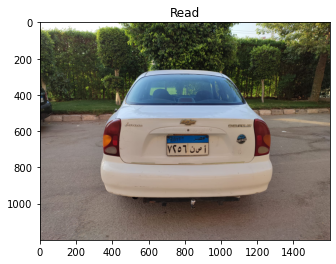

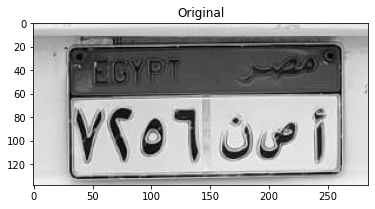

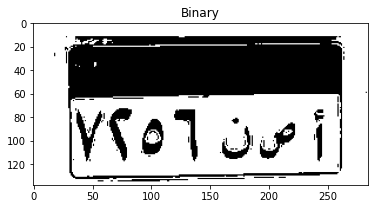

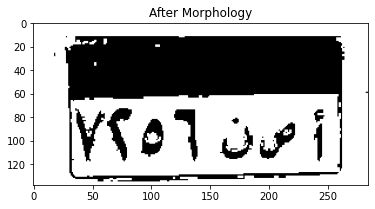

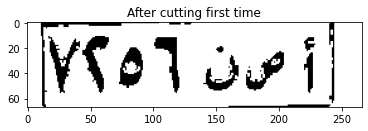

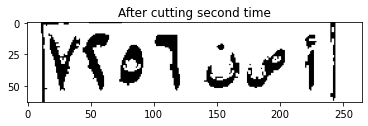

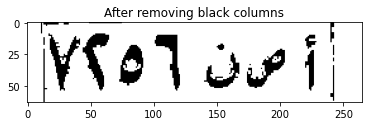

['أ', 'ص', 'ن', '6', '5', '2', '7']
Accepted


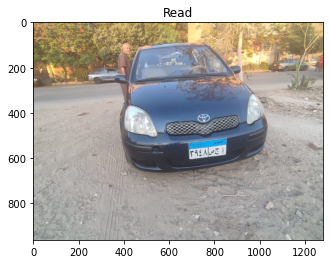

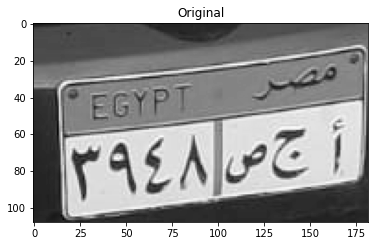

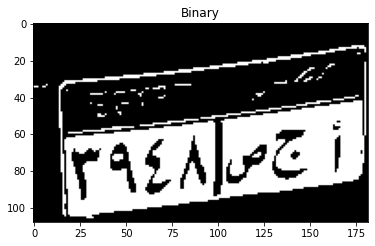

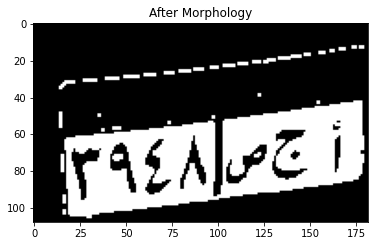

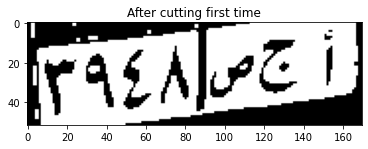

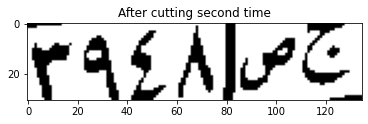

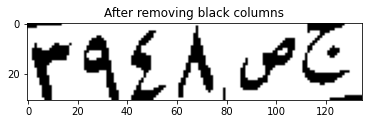

['ق', 'ص', '4', '9', '3']
Rejected


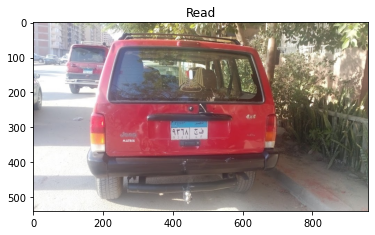

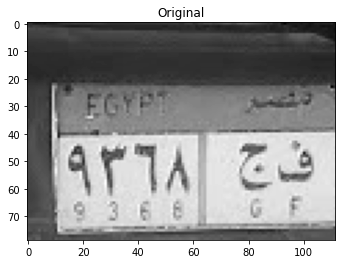

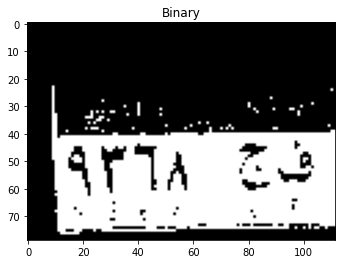

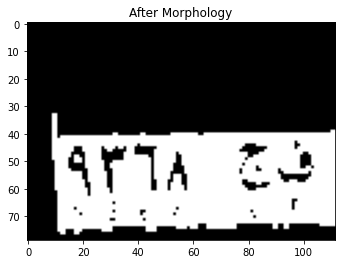

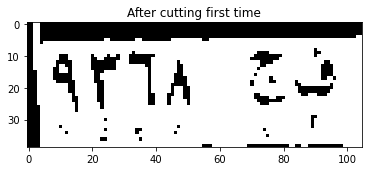

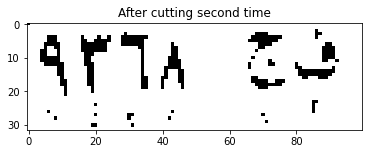

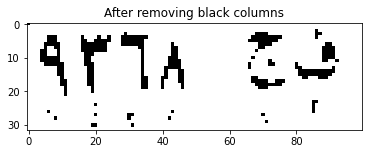

['8', '6', '3', '9']
Rejected


In [28]:
n = 0
page = 3
limit = 20
for i in os.listdir('../dataset/'):
    n += 1
    if (n >= page*limit):
        imageRead = mpimg.imread("../dataset/"+i).astype(np.uint8)[:,:,:3]
        show_images([imageRead], ["Read"])
        image = (rgb2gray(plateDetect(imageRead))*255).astype("uint8")
        show_images([image], ["Original"])
        image = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
        show_images([image], ["Binary"])
        x,y = image.shape
        structuringEl = np.ones((2, 2))        
        image = binary_opening(image, structuringEl)
        show_images([image], ["After Morphology"])
        image = image[int(x//2.2):x-int(x//15),int(y//15):]
        show_images([image], ["After cutting first time"])
        image = cropPlate(image)
        show_images([image], ["After cutting second time"])
        image = removeBlackColumns(image)
        show_images([image], ["After removing black columns"])
        charText = getChars(image)
        print(charText)
        if(checkInDatabase(charText, 'database.txt') == True):
            print('Accepted')
        else:
            print('Rejected')
    if n == (page+1)*limit:
        break
        
# No. errors = 12 out of 19  => Page 0
# No. errors = 11 out of 20  => Page 1
# No. errors = 10 out of 20 => Page 2
# No. errors = 2 out of 3 => Page 3
# Total No. errors = 35 out of 62 
# Success Percentage = 43.5484%, Error percentage = 56.4516%


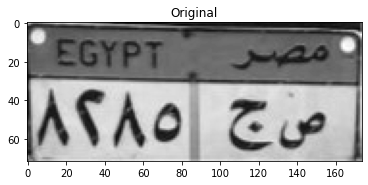

['ص', 'ج', '5', '8', '2', '8']


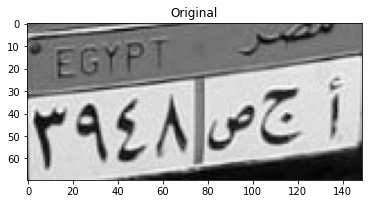

['أ', 'ج', 'ص', '8', '4', '9']


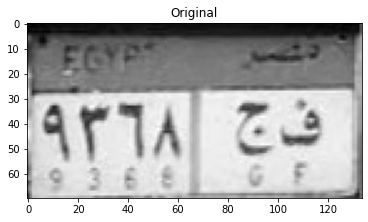

['8', '6', '3', '9']


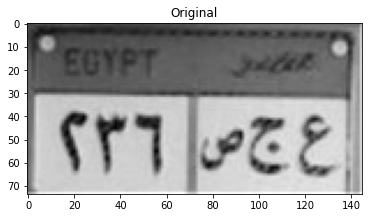

['ع', 'ج', 'ص', '6', '3', '2']


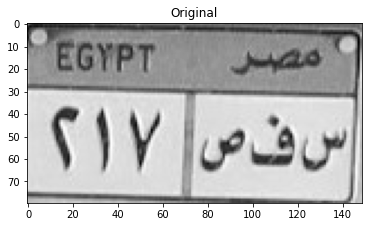

['س', 'ف', 'ص', '7', '1', '2']


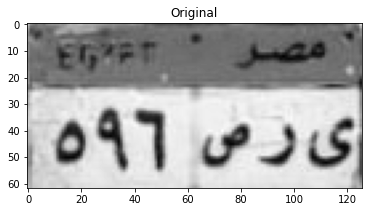

['ى', 'ر', 'ص', '6', '9', '5']


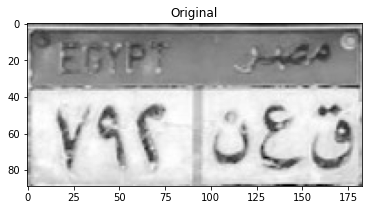

['ق', 'ع', 'ن', '2', '9', '7']


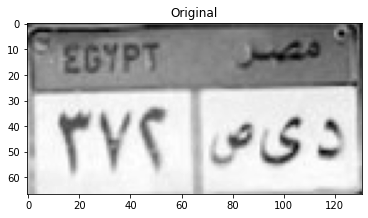

['ى', '2', '1', '3']


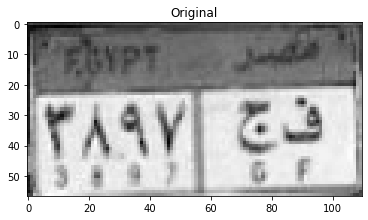

['ف', '7', '9', '8', '3']


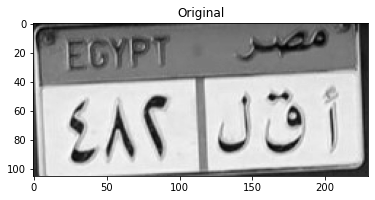

['ق', 'ب', 'ل', '2', '8', 'ف', '4']


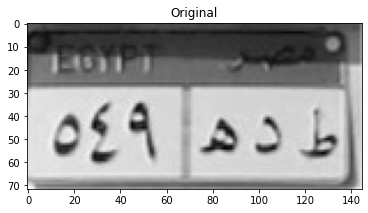

['ط', 'ه', '9', '4']


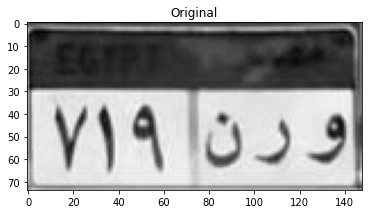

['و', 'ر', 'ن', '9', '1', '7']


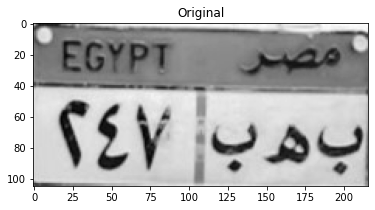

['ب', 'ه', 'ب', '7', '4', '2']


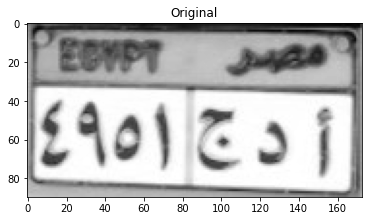

['أ', 'د', '0', 'ق', '1', '5', '9', '4']


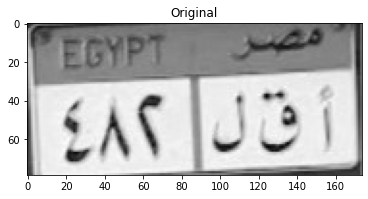

['2', '8', '4']


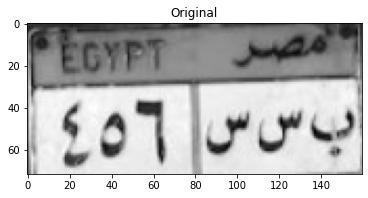

['ب', 'س', 'س', '6', '5', '4']


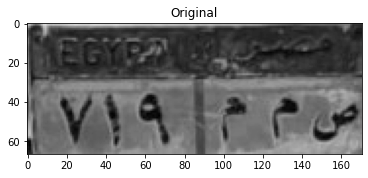

['ص', 'م', 'م', '9', '1', '7']


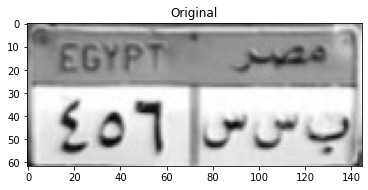

['ب', 'س', 'س', '6', '5', '4']


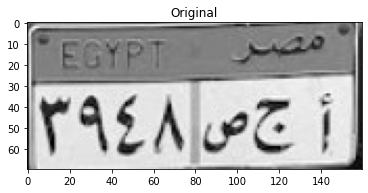

['أ', 'ج', 'ص', '8', '4', '9', '3']


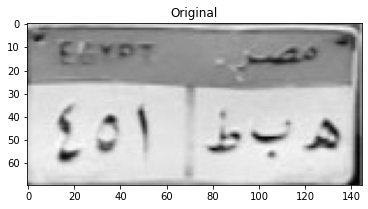

['ه', '1', '4']


In [40]:
n = 0
page = 0
limit = 20
for i in os.listdir('../plates_dataset/'):
    n += 1
    if (n >= page*limit):
        image = (rgb2gray(io.imread("../plates_dataset/" + i)) * 255).astype("uint8")
        show_images([image], ["Original"])
        image = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
        #show_images([image], ["Binary"])
        x,y = image.shape
        structuringEl = np.ones((2, 2))        
        image = binary_opening(image, structuringEl)
        #show_images([image], ["After Morphology"])
        image = image[int(x//2.2):x-int(x//15),int(y//30):y-int(y//29)]
        #show_images([image], ["After cutting"])
        image = cropPlate(image)
        #show_images([image], ["After cutting second time"])
        image = removeBlackColumns(image)
        #show_images([image], ["After removing black columns"])
        charText = getChars(image)
        print(charText)
    if n == (page+1)*limit:
        break

# No. errors = 7 out of 19  => Page 0
# No. errors = 10 out of 20  => Page 1
# No. errors = 10 out of 20 => Page 2
# No. errors = 10 out of 21 => Page 3
# No. errors = 37 out of 80
# Success Percentage = 53.75%, Error percentage = 46.25%